In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import re
import shutil
import argparse
import logging
import ast
import itertools
from StringIO import StringIO

import numpy as np
import pandas as pd
from skimage import io, filters, measure, feature, exposure, color, morphology, draw
from skimage.feature import register_translation
from skimage import transform as tf
import fabio as fb
import mahotas as mh

import scipy.ndimage as ndi
import vigra

from timeit import default_timer as timer
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
import timeit

_MEASUREMENTS = {
    'Label': 'label',
    'Area': 'area',
    'Perimeter': 'perimeter'
}

_MEASUREMENTS_VALS = _MEASUREMENTS.values()

In [3]:
#https://github.com/zenr/ippy

"""
Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
Usage: $ python max_entropy.py <gray scale image>
"""


def max_entropy(data):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    M. Emre Celebi
    06.15.2007
    Ported to ImageJ plugin by G.Landini from E Celebi's fourier_0.8 routines
    2016-04-28: Adapted for Python 2.7 by Robert Metchev from Java source of MaxEntropy() in the Autothresholder plugin
    http://rsb.info.nih.gov/ij/plugins/download/AutoThresholder.java
    :param data: Sequence representing the histogram of the image
    :return threshold: Resulting maximum entropy threshold
    """

    # calculate CDF (cumulative density function)
    cdf = data.astype(np.float).cumsum()

    # find histogram's nonzero area
    valid_idx = np.nonzero(data)[0]
    first_bin = valid_idx[0]
    last_bin = valid_idx[-1]

    # initialize search for maximum
    max_ent, threshold = 0, 0

    for it in range(first_bin, last_bin + 1):
        # Background (dark)
        hist_range = data[:it + 1]
        hist_range = hist_range[hist_range != 0] / cdf[it]  # normalize within selected range & remove all 0 elements
        tot_ent = -np.sum(hist_range * np.log(hist_range))  # background entropy

        # Foreground/Object (bright)
        hist_range = data[it + 1:]
        # normalize within selected range & remove all 0 elements
        hist_range = hist_range[hist_range != 0] / (cdf[last_bin] - cdf[it])
        tot_ent -= np.sum(hist_range * np.log(hist_range))  # accumulate object entropy

        # find max
        if tot_ent > max_ent:
            max_ent, threshold = tot_ent, it

    return threshold

In [4]:
def open_data(filepath):
    _, glob_ext = os.path.splitext(os.path.basename(filepath))
    data = None
    
    if os.path.isdir(filepath):
        data = np.asarray([io.imread(os.path.join(filepath, fp)) for fp in sorted(os.listdir(filepath))])
        return data

    if glob_ext == '.raw':
        name, bits, size, ext = parse_filename(filepath)
        data_type = np.float32 if bits == 32 else np.uint8
        data = np.memmap(filepath, dtype=data_type, shape=tuple(reversed(size)))
    else:
        print 'Incorrent file format, or filename.'

    return data

In [5]:
def parse_filename(filepath):
    basename, ext = os.path.splitext(os.path.basename(filepath))

    comps = basename.split('_')
    size = tuple([int(v) for v in comps[-1:][0].split('x')])
    bits = int(re.findall('\d+', comps[-2:-1][0])[0])
    name = '_'.join(comps[:-2])

    return name, bits, size, ext

In [6]:
def open_gdocs(url):
    import requests
    r = requests.get(url)
    data = r.content
    df = pd.read_csv(StringIO(data))
    return df

In [7]:
def get_samples_configs(df):
    columns = {'Offsets (start, end)': 'offset', 
               'Slice bounding box(x, y, w, h)': 'bbox', 
               'Analysis': 'analysis_type', 
               'Type': 'structure', 
               'Radius': 'radius', 
               'Slice folder': 'slice_folder',
               'Particles density': 'density', 
               'Center': 'center', 
               'Priority': 'priority'}

    cols = df.columns[df.columns.isin(columns.keys())]
    
    out = dict.fromkeys(df['Name'].values, None)
    for name in df['Name'].values:
        out[name] = df[df['Name'] == name][cols].to_dict(orient='records')
        out[name] = {columns[k]: tryeval(v) for k, v in out[name][0].items()}
    
    return out

In [8]:
def crop_raw_data(samples, datasets_dir, output_dir, roi=((-225,225),(-300,300),(-300,300))):
    for sample_name, params in samples.iteritems():
        filepath = [os.path.join(datasets_dir, fn) for fn in os.listdir(datasets_dir) if '{}_'.format(sample_name) in fn][0]
        
        data = np.memmap(filepath, dtype=np.float32, shape=params['shape'], mode='r')
        cz, cy, cx = [v/2 for v in data.shape]
        side_sizes = [np.sum(np.abs(r)) for r in roi]
        
        print cz, cy, cx
        
        cropped_data = data[slice(cz+roi[0][0], cz+roi[0][1]),
                            slice(cy+roi[1][0], cy+roi[1][1]),
                            slice(cx+roi[2][0], cx+roi[2][1])]
        
        ofld_name = '{}_{}x{}x{}'.format(sample_name, side_sizes[2], side_sizes[1], side_sizes[0])
        odir = os.path.join(output_dir, ofld_name, 'slices')
        
        if not os.path.exists(odir):
            os.makedirs(odir)
        
        for i, dslice in enumerate(cropped_data):
            io.imsave(os.path.join(odir, 'slice_{:04}.tif'.format(i)), dslice)
            
            if (i % 100 == 0) or (i == cropped_data.shape[0] - 1):
                print '{}/{}'.format(i, cropped_data.shape[0])

# Segmentation

In [9]:
def filter_particles(data, min_eccentricity=0.98):
    lbl = ndi.measurements.label(data)[0]
    regions = measure.regionprops(lbl)
        
    for region in regions:
        circ = (4. * np.pi * region.area) / (region.perimeter ** 2)

        if region.eccentricity > min_eccentricity:
            data[lbl == region.label] = 0

    return data

In [10]:
def check_slice(slice_mask, non_zeros_ratio=0.7):
    dilated_slice_mask = ndi.morphology.binary_dilation(slice_mask, iterations=5).flatten()
    num_nonzeros = np.count_nonzero(dilated_slice_mask)

    if num_nonzeros > dilated_slice_mask.size * non_zeros_ratio:
        return np.zeros_like(slice_mask)
    
    return slice_mask

In [11]:
def segment_sample(samples, input_dir, roi=((-225,225),(-300,300),(-300,300)), 
                   check_slices=True, gauss_sigma=1, fibers_md_rad=0, min_eccentricity=0.98):
    for sample_name, configs in samples.iteritems():
        start = timer()
        
        print 'Sample #' + sample_name

        components = configs['types']
        rng = configs.get('range')
        
        print components
        
        sample_dir = [os.path.join(input_dir, fn) for fn in os.listdir(input_dir) if sample_name in fn][0]
        slices_dir = os.path.join(sample_dir, 'slices')
        
        for i, comp in enumerate(components):
            slice_paths = sorted([os.path.join(slices_dir, fn) for fn in os.listdir(slices_dir)])
            slice_paths = slice_paths[rng] if rng is not None else slice_paths
            
            for fpath in slice_paths:
                cropped_data = io.imread(fpath)
                filename = os.path.basename(fpath)

                p2 = np.percentile(cropped_data, 0.01)
                p98 = np.percentile(cropped_data, 99.99)
        
                cropped_data = ndi.filters.gaussian_filter(cropped_data, gauss_sigma)
                cropped_data = exposure.rescale_intensity(cropped_data, in_range=(p2, p98))
                data_8bit = exposure.rescale_intensity(cropped_data, in_range='image', out_range=np.uint8).astype(np.uint8)
                
                if comp == 'particles':
                    th = max_entropy(np.histogram(data_8bit, bins=256, range=(0, 256))[0])
                    mask = (data_8bit >= th).astype(np.uint8)
                    if check_slices:
                        mask = check_slice(mask)
                    mask = ndi.filters.median_filter(mask, size=2)
                    mask = filter_particles(mask, min_eccentricity=min_eccentricity)
                    
                if comp == 'fibers':
                    th = mh.otsu(data_8bit, ignore_zeros=True)
                    mask = (data_8bit >= th).astype(np.uint8)
                    if fibers_md_rad:
                        mask = ndi.filters.median_filter(mask, size=fibers_md_rad)
                    if check_slices:
                        mask = check_slice(mask)
                    #mask = ndi.morphology.binary_closing(mask, iterations=2)
                    #mask = ndi.morphology.binary_fill_holes(mask)
                    
                if comp == 'fibers_no_particles':
                    th_particles = max_entropy(np.histogram(data_8bit, bins=256, range=(0, 256))[0])
                    th_fibers = mh.otsu(data_8bit, ignore_zeros=True)
                    
                    mask_particles = (data_8bit >= th_particles).astype(np.uint8)
                    mask_fibers = (data_8bit >= th_fibers).astype(np.uint8)
                    
                    if check_slices:
                        mask_particles = check_slice(mask_particles)
                        mask_fibers = check_slice(mask_fibers)
                    
                    if not np.count_nonzero(mask_particles * mask_fibers):
                        mask = np.zeros_like(mask_fibers)
                    else:
                        mask = mask_fibers.astype(np.int8) - ndi.morphology.binary_dilation(mask_particles, 
                                                                            structure=morphology.disk(2),
                                                                            iterations=2).astype(np.int8)
                        mask[mask < 0] = 0
                    
                out_dir = os.path.join(sample_dir, comp)
                  
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                    
                io.imsave(os.path.join(out_dir, filename), mask.astype(np.uint8))
            
        end = timer()
        print end - start

In [12]:
def raw2slices(input_path, output_dir, out_fld='slices', file_fmt='slice_{}.tif'):
    name, bits, size, ext = parse_filename(input_path)
    data = open_data(input_path)
    
    output_path = os.path.join(output_dir, name, out_fld)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    print input_path
    
    for idx, _slice in enumerate(data):
        if idx % 100 == 0 or idx == data.shape[0]-1:
            print '{}/{}'.format(idx, data.shape[0]-1)
            
        io.imsave(os.path.join(output_path, file_fmt.format(idx)), _slice)

# Segment samples for porosity

In [19]:
por_samples = {'sample23': {'types': ['particles', 'fibers', 'fibers_no_particles']},
               'sample24': {'types': ['particles', 'fibers', 'fibers_no_particles'], 
                            'rngs': {'particles':[0,185]}},
               'sample25': {'types': ['particles', 'fibers', 'fibers_no_particles']},
               'sample26': {'types': ['particles', 'fibers', 'fibers_no_particles']},
               'sample27': {'types': ['particles', 'fibers', 'fibers_no_particles']},
               'sample28': {'types': ['particles', 'fibers', 'fibers_no_particles']}}

In [14]:
segment_sample(por_samples, './data/samples/porosity', 
               check_slices=False,
               min_eccentricity=0.98)

Sample #sample28
['particles', 'fibers', 'fibers_no_particles']
188.742501974
Sample #sample23
['particles', 'fibers', 'fibers_no_particles']
163.271644115
Sample #sample24
['particles', 'fibers', 'fibers_no_particles']
195.057714224
Sample #sample25
['particles', 'fibers', 'fibers_no_particles']
231.561881065
Sample #sample26
['particles', 'fibers', 'fibers_no_particles']
212.578463078
Sample #sample27
['particles', 'fibers', 'fibers_no_particles']
185.142102957


In [13]:
_MEASUREMENTS = {
    'Label': 'label',
    'Area': 'area',
    'Perimeter': 'perimeter'
}

_MEASUREMENTS_VALS = _MEASUREMENTS.values()

def object_counter(stack_binary_data):
    print 'Object counting - Labeling...'
    labeled_stack, num_labels = ndi.measurements.label(stack_binary_data)
    objects_stats = pd.DataFrame(columns=_MEASUREMENTS_VALS)
    
    print 'Object counting - Stats gathering...'
    for slice_idx in np.arange(labeled_stack.shape[0]):
        for region in measure.regionprops(labeled_stack[slice_idx]):
            objects_stats = objects_stats.append({_measure: region[_measure] \
                                        for _measure in _MEASUREMENTS_VALS}, \
                                            ignore_index=True)
            
    print 'Object counting - Stats grouping...'
    objects_stats = objects_stats.groupby('label', as_index=False).sum()

    return objects_stats, labeled_stack

In [14]:
def estimate_particles(samples, input_dir):
    for sample_name, configs in samples.items():
        components = configs['types']
        
        if 'particles' in components:
            print '###### Processing of {}'.format(sample_name)
            
            sample_dir = [os.path.join(input_dir, fn) for fn in os.listdir(input_dir) if '{}_'.format(sample_name) in fn][0]
            
            slices_dir = os.path.join(sample_dir, 'particles')
            slice_paths = sorted([os.path.join(slices_dir, fn) for fn in os.listdir(slices_dir)])
            input_data = np.array([io.imread(fp) for fp in slice_paths])
            
            objects_stats, labeled_data = object_counter(input_data)
            output_path = os.path.join(input_dir, sample_dir, 'Analysis')

            print 'Data storing - Stats and data saving...'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            objects_stats.to_csv(os.path.join(output_path, 'particles_stats_{}.csv'.format(sample_name)))
        else:
            print '###### Processing of {} skipped'.format(sample_name)

In [15]:
def estimate_material_relation(sample_name, input_dir, slice_folder, relation_name, rng=None, inverse=False):
    print '###### Processing of {}'.format(sample_name) 
        
    sample_dir = [os.path.join(input_dir, fn) for fn in os.listdir(input_dir) if sample_name in fn][0]
    slices_dir = os.path.join(sample_dir, slice_folder)
        
    print 'Data processing - Opening...'
            
    slice_paths = sorted([os.path.join(slices_dir, fn) for fn in os.listdir(slices_dir)])
    if rng is None:
        rng = [0, len(slice_paths)-1]
    
    input_data = np.array([io.imread(fp) for fp in slice_paths[rng[0]:rng[-1]]])
   
    total_volume = input_data[0].size * len(slice_paths)
    material_volume = np.count_nonzero(input_data)
    print '{}/{}'.format(total_volume, material_volume)
            
    output_path = os.path.join(input_dir, sample_dir, 'Analysis')
            
    print 'Data storing - Stats and data saving...'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    relation = material_volume / float(total_volume)
    
    if inverse: 
        relation = 1. - relation
        
    print 'Relation {}: {}'.format(relation_name, relation)
            
    np.savetxt(os.path.join(output_path, 'relation_{}_{}.txt'.format(relation_name, sample_name)), [relation])

In [16]:
# porosity; calcium; polymer
# dimater
# orientation


In [17]:
def calc_relations(samples, input_dir):
    _name_code = {
        'fibers': 'porosity',
        'particles': 'calcium',
        'fibers_no_particles': 'polymer'
    }
    
    for sample_name, configs in samples.items():
        components = configs['types']
        
        for comp in components:
            inv = True if comp == 'fibers' else False
            rng = configs['rngs'][comp] if ('rngs' in configs) and (comp in configs['rngs']) else None 
            estimate_material_relation(sample_name, input_dir, comp, _name_code[comp], rng=rng, inverse=inv)

In [25]:
calc_relations(por_samples, './data/samples/porosity')

###### Processing of sample28
Data processing - Opening...
225000000/5304542
Data storing - Stats and data saving...
Relation calcium: 0.0235757422222
###### Processing of sample28
Data processing - Opening...
225000000/65241907
Data storing - Stats and data saving...
Relation porosity: 0.710035968889
###### Processing of sample28
Data processing - Opening...
225000000/54662018
Data storing - Stats and data saving...
Relation polymer: 0.242942302222
###### Processing of sample23
Data processing - Opening...
225000000/6887100
Data storing - Stats and data saving...
Relation calcium: 0.0306093333333
###### Processing of sample23
Data processing - Opening...
225000000/27086933
Data storing - Stats and data saving...
Relation porosity: 0.879613631111
###### Processing of sample23
Data processing - Opening...
225000000/18332025
Data storing - Stats and data saving...
Relation polymer: 0.0814756666667
###### Processing of sample24
Data processing - Opening...
225000000/10565908
Data storing 

# Segment samples for orientation

In [27]:
seg_samples = {'sample23': {'types': ['fibers']},
               'sample24': {'types': ['fibers']},
               'sample27': {'types': ['fibers']},
               'sample28': {'types': ['fibers']}}

In [134]:
segment_sample(seg_samples,
               './data/samples/data_for_orientation_and_diameter', 
               fibers_md_rad=3, 
               check_slices=False, 
               min_eccentricity=0.98)

Sample #sample28
['fibers']
8.49865818024
Sample #sample23
['fibers']
7.56424808502
Sample #sample24
['fibers']
8.79229283333
Sample #sample27
['fibers']
6.73591995239


# Orientation and diameter

In [18]:
def prepare_data(data, dilate_iterations=1, sigma=0.5):
    data_8bit = data.astype(np.uint8)
    data_8bit = ndi.binary_fill_holes(data_8bit).astype(np.uint8)
    skeleton = morphology.skeletonize_3d(data_8bit)
    
    skeleton_thick = ndi.binary_dilation(skeleton, iterations=dilate_iterations).astype(np.float32)
    skeleton_thick = ndi.filters.gaussian_filter(skeleton_thick, sigma)
    
    return data_8bit, skeleton, skeleton_thick

In [19]:
def orientation_3d_tensor_vigra(data, sigma=0.1):
    img = vigra.filters.structureTensor(data, 1, 1, sigma_d=sigma)
    Axx = img[:,:,:,0]
    Axy = img[:,:,:,1]
    Axz = img[:,:,:,2]
    Ayy = img[:,:,:,3]
    Ayz = img[:,:,:,4]
    Azz = img[:,:,:,5]
        
    tensor_vals = np.array([[np.mean(Azz), np.mean(Ayz), np.mean(Axz)],
                            [np.mean(Ayz), np.mean(Ayy), np.mean(Axy)],
                            [np.mean(Axz), np.mean(Axy), np.mean(Axx)]])
    
    tensor_vals = tensor_vals[::-1,::-1]
    
    eps = 1e-8
    w, v = np.linalg.eig(tensor_vals)

    mv = v[:, np.argmin(w)] # z, y, x
    mv[np.abs(mv) < eps] = 0
    #print "MV: ", mv
      
    G = np.sqrt(mv[2]**2 + mv[1]**2)
    #print "M0 ** 2 + G ** 2 = ", np.sqrt(mv[0] ** 2 + G ** 2)
    
    #lat =  - np.arctan(G / mv[0]) if mv[0] else np.pi/2.
    lat = np.arcsin(np.around(G, decimals=3))
    azth = np.arctan(mv[1] / mv[2]) if mv[2] else np.pi/2.
#     if azth > 0.:
#         azth = np.pi/2. - azth
#     else:
#         azth = -np.pi/2. - azth
    
    return lat, azth

In [20]:
def estimate_tensor(sample_name, skel, data, window_size, output_dir, sigma=0.025, make_output=True):
    output_props = dict()
    
    Z, Y, X = skel.nonzero()
    tens_lat_arr = np.zeros_like(skel, dtype=np.float32)
    tens_azth_arr = np.zeros_like(skel, dtype=np.float32)
    skel_est = np.zeros_like(skel, dtype=np.int32)
    
    ws = np.uint32(window_size)
    ws2 = ws/2
    skel_shape = skel.shape
    
    output_props['sample_name'] = sample_name
    
    ts = time.time()
    
    for idx, pt in enumerate(zip(Z, Y, X)):
        lim0 = pt - ws2
        lim1 = pt + ws2
        
        if any(np.array(lim0) < 0) or any(np.array(lim1) > (np.array(skel_shape) - 1)):
            skel_est[pt] = -1
            continue
                
        z0, y0, x0 = lim0
        z1, y1, x1 = lim1
        
        area = data[z0:z1, y0:y1, x0:x1]
               
        
        lat, azth = orientation_3d_tensor_vigra(area, sigma)
        
        tens_lat_arr[pt] = lat
        tens_azth_arr[pt] = azth
        skel_est[pt] = 255
        
    te = time.time()
    output_props['time'] = te-ts
    
    print "Tensor time: %fs" % (output_props['time'])
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    if make_output:
        opath = os.path.join(output_dir, '{}_w{}_orientation_evaluation.npy').format(sample_name, window_size)
        output_props['opath'] = opath
        
        output = {'lat': tens_lat_arr, 'azth': tens_azth_arr, 'skeleton': skel_est, 'indices': skel_est > 0}
        output['props'] = output_props
        np.save(opath, output)
    
    return output_props

In [21]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda

In [22]:
def numpy3d_to_array(np_array, allow_surface_bind=True):
    # numpy3d_to_array
    # this function was
    # taken from pycuda mailing list (striped for C ordering only)

    d, h, w = np_array.shape

    descr = cuda.ArrayDescriptor3D()
    descr.width = w
    descr.height = h
    descr.depth = d
    descr.format = cuda.dtype_to_array_format(np_array.dtype)
    descr.num_channels = 1
    descr.flags = 0

    if allow_surface_bind:
        descr.flags = cuda.array3d_flags.SURFACE_LDST

    device_array = cuda.Array(descr)

    copy = cuda.Memcpy3D()
    copy.set_src_host(np_array)
    copy.set_dst_array(device_array)
    copy.width_in_bytes = copy.src_pitch = np_array.strides[1]
    copy.src_height = copy.height = h
    copy.depth = d

    copy()

    return device_array

In [23]:
def run_gpu_diameter(data_skel, data_azth, data_lat, data_rad, n_scan_angl=12):
    program = SourceModule("""
    
    texture<float, cudaTextureType3D, cudaReadModeElementType> tex_in_azth;
    texture<float, cudaTextureType3D, cudaReadModeElementType> tex_in_lat;
    texture<float, cudaTextureType3D, cudaReadModeElementType> tex_in_skel;
    texture<float, cudaTextureType3D, cudaReadModeElementType> tex_in_rad;

    __global__ void diameter3d(int dW, int dH, int dD,
                               const float *scan_angl_arr,
                               int n_scan_angl,
                               float *radius_arr)
    {
        unsigned int xidx_ = threadIdx.x + blockDim.x * blockIdx.x;

        unsigned int ix = xidx_ % dW;
        unsigned int iy = threadIdx.y + blockDim.y * blockIdx.y;
        unsigned int iz = xidx_ / dW;

        if (ix >= dW || iy >= dH || iz >= dD){
            return;
        }

        float _x = (float)ix + 0.5;
        float _y = (float)iy + 0.5;
        float _z = (float)iz + 0.5;
        
        if (tex3D(tex_in_skel, _x, _y, _z) == 0) {
            return;
        }

        // -----------------------------------------
        // Find the diameter
        
        float best_azth = tex3D(tex_in_azth, _x, _y, _z);
        float best_lat = tex3D(tex_in_lat, _x, _y, _z);
        
        float best_dz = cos(best_lat);
        float dxy = sin(best_lat);
        float best_dx = cos(best_azth) * dxy;
        float best_dy = -sin(best_azth) * dxy;
        
        float cy = cosf(best_lat), sy = sinf(best_lat);
        float cz = cosf(-best_azth), sz = sinf(-best_azth);
        
        float scan_vec[3] = {1, 0, 0};
        float rot_scan_vec[3] = {scan_vec[0]*cy*cz - scan_vec[1]*sy + scan_vec[2]*cz*sy, 
                                 scan_vec[0]*sz*cy + scan_vec[1]*cz + scan_vec[2]*sy*sz, 
                                 -scan_vec[0]*sy + scan_vec[2]*cy};
                                
        float min_radius = dD;
        float max_radius = -1;
        int max_iters = 20;
                                
        for (int scan_angl_idx = 0; scan_angl_idx < n_scan_angl; scan_angl_idx++) {                    
            float theta = scan_angl_arr[scan_angl_idx];
            
            float ct = cosf(theta), st = sinf(theta);
            float x = rot_scan_vec[0], y = rot_scan_vec[1], z = rot_scan_vec[2];
            float u = best_dx, v = best_dy, w = best_dz;
            
            float scan_vec_coords[3] = 
                    {u*(u*x + v*y + w*z)*(1.0f - ct) + x*ct + (-w*y + v*z)*st,
                     v*(u*x + v*y + w*z)*(1.0f - ct) + y*ct + (w*x - u*z)*st,
                     w*(u*x + v*y + w*z)*(1.0f - ct) + z*ct + (-v*x + u*y)*st};
            
            float nc[3] = {_x, _y, _z};
            float p[3];
            
            for (int i = 0; i < max_iters; i++) {
                nc[0] += scan_vec_coords[0];
                nc[1] += scan_vec_coords[1];
                nc[2] += scan_vec_coords[2];
                
                if ((tex3D(tex_in_rad, nc[0], nc[1], nc[2]) == 0) &&
                    (nc[0] >= 0 && nc[0] < dW) &&
                    (nc[1] >= 0 && nc[1] < dH) &&
                    (nc[2] >= 0 && nc[2] < dD)) {
                    
                    p[0] = nc[0];
                    p[1] = nc[1];
                    p[2] = nc[2];
                    break;
                }
            }
            
            float cur_radius = norm3df(p[0] - _x, p[1] - _y, p[2] - _z);

            if (cur_radius < min_radius) {
                min_radius = cur_radius;
            }
        }
        
        int output_index = ix + iy * dW + iz * (dW * dH);
       
        radius_arr[output_index] = min_radius;
    }
    """)

    # ---- Generate data
    data_skel = np.float32(data_skel)
    data_azth = np.float32(data_azth)
    data_lat = np.float32(data_lat)
    data_rad = np.float32(data_rad)
    
    data_len = reduce(lambda x,y: x * y, data_skel.shape)
    
    print "Data generated!"

    # ---- Allocate memory for results
    radius_arr = np.zeros(data_len, dtype=np.float32)

    # ---- Generate angles
    n_scan_angl = np.int32(n_scan_angl)
    scan_angl_arr = np.float32(np.linspace(0, 360, num=n_scan_angl, endpoint=False))
    scan_angl_arr = np.deg2rad(scan_angl_arr)
    
    # ---- Set values
    dD, dH, dW = np.int32(data_skel.shape)
    print "dW, dH, dD", dW, dH, dD

    # ---- Allocate gpu memory
    gpu_scan_angl_arr = cuda.mem_alloc(scan_angl_arr.nbytes)
    gpu_radius_arr = cuda.mem_alloc(radius_arr.nbytes)

    # ---- Copy host to device
    cuda.memcpy_htod(gpu_scan_angl_arr, scan_angl_arr)
    cuda.memcpy_htod(gpu_radius_arr, radius_arr)

    # ---- Get kernel
    diameter3d = program.get_function("diameter3d")

    # ---- Bind texture
    tex_in_azth = program.get_texref('tex_in_azth')
    cuda_array_in_azth = numpy3d_to_array(data_azth)
    tex_in_azth.set_array(cuda_array_in_azth)
    
    tex_in_lat = program.get_texref('tex_in_lat')
    cuda_array_in_lat = numpy3d_to_array(data_lat)
    tex_in_lat.set_array(cuda_array_in_lat)
    
    tex_in_skel = program.get_texref('tex_in_skel')
    cuda_array_in_skel = numpy3d_to_array(data_skel)
    tex_in_skel.set_array(cuda_array_in_skel)

    tex_in_rad = program.get_texref('tex_in_rad')
    cuda_array_in_rad = numpy3d_to_array(data_rad)
    tex_in_rad.set_array(cuda_array_in_rad)
    
    # Compute dimensions and run the kernel
    # NOTE: No support for 3D grid in pycuda
    bdim = (16, 32, 1)
    dx, mx = divmod(dD * dH, bdim[0])
    dy, my = divmod(dW, bdim[1])
    gdim = ((dx + (mx > 0)) * bdim[0],
            (dy + (my > 0)) * bdim[1])

    start = cuda.Event()
    end = cuda.Event()

    start.record()  # start timing
    diameter3d(dW, dH, dD,
               gpu_scan_angl_arr,
               n_scan_angl,
               gpu_radius_arr,
               block=bdim,
               grid=gdim)

    end.record()  # end timing
    end.synchronize()
    secs = start.time_till(end)*1e-3

    # Copy result from device to host memory
    cuda.memcpy_dtoh(radius_arr, gpu_radius_arr)
    
    gpu_radius_arr.free()
    gpu_scan_angl_arr.free()
    
    cuda_array_in_azth.free()
    cuda_array_in_lat.free()
    cuda_array_in_skel.free()
    cuda_array_in_rad.free()

    return radius_arr, secs

In [24]:
def quantify_diameter(sample_name, data_skel, data_azth, data_lat, data_rad, n_scan_angl, output_dir, do_reshape=True):
    data_skel[data_skel < 0] = 0
    dmtr, elapsed_time = run_gpu_diameter(data_skel, data_azth, data_lat, data_rad, n_scan_angl=n_scan_angl)
    
    print 'Diameter time: {}s'.format(elapsed_time)

    if do_reshape:
        dmtr = np.reshape(dmtr, data_skel.shape, order='C')
        
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    opath = os.path.join(output_dir, '{}_nsa{}_diameter_evaluation.npy').format(sample_name, n_scan_angl)
    output_props = {'opath': opath, 'time': elapsed_time, 'sample_name': sample_name}  
    output = {'diameter': dmtr, 'skeleton': data_skel, 'indices': data_skel > 0, 'props': output_props}
    np.save(opath, output)
    
    return output_props

In [25]:
def estimate_fiber_properties(samples, input_dir, window_size=32, num_scanning_angles=30, type='fibers'):
    for sample_name, configs in samples.items():
        print '###### Orientation and diameter processing of {}'.format(sample_name) 
        
        bin_data = open_data(os.path.join(input_dir, sample_name, type))
        data_8bit, skel, skel_thick = prepare_data(bin_data)
        analysis_odir = os.path.join(input_dir, sample_name, 'Analysis')
        
        orient_props = estimate_tensor(sample_name, skel, skel_thick, 
                                       window_size, analysis_odir)
        orient_data = np.load(orient_props['opath']).item()
        
        diamtr_props = quantify_diameter(sample_name,
                                         orient_data['skeleton'], 
                                         orient_data['azth'],
                                         orient_data['lat'],
                                         data_8bit,
                                         num_scanning_angles,
                                         analysis_odir)

In [28]:
estimate_fiber_properties(seg_samples, './data/samples/data_for_orientation_and_diameter')

###### Orientation and diameter processing of sample28
Tensor time: 11148.310622s
Data generated!
dW, dH, dD 750 750 100
Diameter time: 1.03463342285s
###### Orientation and diameter processing of sample23
Tensor time: 8814.686372s
Data generated!
dW, dH, dD 750 750 100
Diameter time: 1.0147175293s
###### Orientation and diameter processing of sample24
Tensor time: 10224.037585s
Data generated!
dW, dH, dD 750 750 100
Diameter time: 1.03901794434s
###### Orientation and diameter processing of sample27
Tensor time: 8159.413620s
Data generated!
dW, dH, dD 750 750 100
Diameter time: 0.992719726563s


# Orient test

In [45]:
bin_data = open_data(os.path.join('./data/samples/data_for_orientation_and_diameter', 
                                  'sample23',
                                  'fibers'))
data_8bit, skel, skel_thick = prepare_data(bin_data)

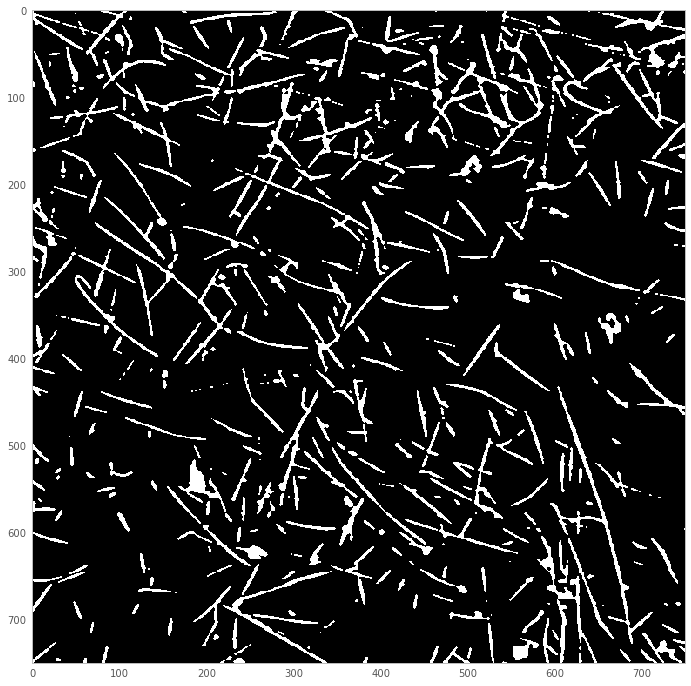

In [51]:
plt.figure(figsize=(12,12))
plt.imshow(data_8bit[60])